In [131]:
# This notebook was created to analyse the questionnaire and scale data for the ayahuasca AVH project 
# was last edited Feb. 11th 2025 by Ana Hoban

In [132]:
#import statements

import numpy as np
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
from collections import Counter
import csv
import datetime as dt
import re
import scipy.stats as sc
from scipy.stats import fisher_exact, mannwhitneyu
from scipy.stats.contingency import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar
import statsmodels.api as sm
import seaborn as sns

## Functions

In [133]:
def get_percentages(df, cols = [23,24,37,38]):
    errors = []
    
    #prevalence of voice-hearing in our sample
    stat_yes_avh = df[df.columns[24]].value_counts('Yes')['Yes'] 

    #standard error
    se_yes = np.sqrt(stat_yes_avh*(1-stat_yes_avh)/100)
    z = 1.96 #critical value
    margin = se_yes*z #margin of error
    errors.append(margin)
    ci = [stat_yes_avh - margin, stat_yes_avh + margin] #95% confidence interval 

    print(f'The prevalence of AVH without any drugs is {stat_yes_avh*100 :.2f} (95% CI: [{ci[0]*100:.2f},{ci[1]*100:.2f}]')

    #prevalence of voice-hearing in our sample
    stat_yes_other = df[df.columns[23]].value_counts('Yes')['Yes'] 

    #standard error
    se_yes = np.sqrt(stat_yes_other*(1-stat_yes_other)/100)
    z = 1.96 #critical value
    margin = se_yes*z #margin of error
    errors.append(margin)
    ci = [stat_yes_other - margin, stat_yes_other + margin] #95% confidence interval 

    print(f'The prevalence of AVH during any drugs is {stat_yes_other*100 :.2f} (95% CI: [{ci[0]*100:.2f},{ci[1]*100:.2f}]')


    #stats during ayahuasca
    stat_avh_during = df.iloc[:,37].value_counts('Yes')['Yes']

    #standard error
    se_yes = np.sqrt(stat_avh_during*(1-stat_avh_during)/100)
    z = 1.96 #critical value
    margin = se_yes*z #margin of error
    errors.append(margin)
    ci = [stat_avh_during - margin, stat_avh_during+ margin] #95% confidence interval 

    print(f'{stat_avh_during*100 :.2f} (95% CI: [{ci[0]*100:.2f},{ci[1]*100:.2f}] % of ppl report AVH during ayahuasca')


    #stats after ayahuasca
    stat_avh_after = df.iloc[:,38].value_counts('Yes')['Yes']

    #standard error
    se_yes = np.sqrt(stat_avh_after*(1-stat_avh_after)/100)
    z = 1.96 #critical value
    margin = se_yes*z #margin of error
    errors.append(margin)
    ci = [stat_avh_after - margin, stat_avh_after+ margin] #95% confidence interval 

    print(f'{stat_avh_after*100 :.2f} (95% CI: [{ci[0]*100:.2f},{ci[1]*100:.2f}] % of ppl report AVH after ayahuasca')
    
    return [stat_yes_avh, stat_yes_other, stat_avh_during, stat_avh_after], errors

In [134]:
def stat_test(df, col1, col2, paired=False):
    """
    Performs appropriate statistical test (McNemar's, Fisher's exact, or Chi-squared).

    Args:
        df: Pandas DataFrame.
        col1: Name of the first column.
        col2: Name of the second column.
        paired: True if the data is paired, False otherwise.

    Returns:
        A dictionary containing the test results:
            'test_name': Name of the test performed.
            'p_value': P-value of the test.
            'statistic': Test statistic.
            'effect_size': Effect size measure (odds ratio for Fisher's, Cramer's V for Chi-squared).
            'warning': A warning message if applicable.
    """
    
    #compute the contingency table
    contingency_table = pd.crosstab(df[col2], df[col1]).dropna() #.to_numpy()
    
    if paired:
        col1_unique = df[col1].dropna().unique()
        col2_unique = df[col2].dropna().unique()
        
        if len(col1_unique) != 2 or len(col2_unique) != 2:  # Corrected condition            print('issue')
            raise ValueError(f"Statistical test cannot be performed when either '{col1}' or '{col2}' has only one unique value.")
            return {'test_name': 'none', 'p_value': None, 'statistic': None, 'effect_size': None, 'warning': 'All answers are the same'}

        result = mcnemar(contingency_table, correction=True) #correction added!
        return {'test_name': 'McNemar\'s', 'p_value': result.pvalue, 'statistic': result.statistic, 'dof': None, 'effect_size': None, 'warning': None}

    if contingency_table.shape == (2, 2):
        # Calculate expected counts
        expected = chi2_contingency(contingency_table)[3]
        if np.any(expected < 5):  # Check expected counts!
            #rint(f"Running Fisher's exact test for {col1}, {col2}")
            odds_ratio, p_value = fisher_exact(contingency_table)
            return {'test_name': 'Fisher\'s exact', 'p_value': p_value, 'statistic': None, 'effect_size': odds_ratio, 'warning': None}
        else:
            #rint(f"Running Chi-squared test for {col1}, {col2} (2x2 table)")
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            cramers_v = np.sqrt((chi2 / contingency_table.sum())*min(contingency_table.shape[0]-1, contingency_table.shape[1]-1))
            return {'test_name': 'Chi-squared', 'p_value': p_value, 'statistic': chi2, 'dof': dof, 'effect_size': cramers_v, 'warning': None}

    else:  # Not a 2x2 table
        #rint(f"Running Chi2 test for {col1}, {col2}")
        expected = chi2_contingency(contingency_table)[3]
        if np.any(expected < 5):
            warning_message = f"Chi-squared test might be unreliable for {col1} and {col2} due to small expected cell counts. Consider simulation."
        else:
            warning_message = None

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        cramers_v = np.sqrt((chi2 / contingency_table.sum())*min(contingency_table.shape[0]-1, contingency_table.shape[1]-1))

        return {'test_name': 'Chi-squared', 'p_value': p_value, 'statistic': chi2, 'dof': dof, 'effect_size': cramers_v, 'warning': warning_message}

In [135]:
def run_fisher_test(contingency_table):
    """
    Running Fisher's test 

    """

    odds_ratio, p_value = fisher_exact(contingency_table)


    # One-sided test (optional):
    # By default, fisher_exact performs a two-sided test. 
    # You can specify a one-sided test using the alternative parameter:
    #   - 'less':  H1: odds ratio < 1
    #   - 'greater': H1: odds ratio > 1
    #   - 'two-sided' (default): H1: odds ratio != 1

    return p_value, odds_ratio

In [136]:
def run_mcnemar_test(contingency_table):
    """
    Performs McNemar's test on two paired categorical columns (before and after responses). Works on dichotomous data

    Parameters:
    df (pd.DataFrame): The dataset.
    col_before (str or int): The column name or index representing the "before" responses.
    col_after (str or int): The column name or index representing the "after" responses.

    Returns:
    float: The p-value from McNemar's test.
    """

    # Convert to numpy array for McNemar test
    table = contingency_table.values

    # Run McNemar's test
    result = mcnemar(table, exact=True) #what about third param

    return result.pvalue, result.statistic


In [137]:
def run_chi_square_test(contingency_table):
    """
    Performs a Chi-Square test for independence between gender and a Yes/No question response. 
    If there are cells with counts of less than 5, the 

    Parameters:
    df (pd.DataFrame): The dataset.
    question_col (str): Column name of the Yes/No question.
    gender_col (str): Column name of the gender variable.
    corr: the number of stats test for the correction of the significance threshold.

    Returns:
    float: The p-value from the Chi-Square test.
    """
        
    # Perform Chi-Square test if there are more than 5 counts in all cells
    chi2, p_value, dof, expected = sc.chi2_contingency(contingency_table)
    
    #Calculates n for Cramer's V for a contingency table
    #this is an effect size measurement for the chi-squared test of independence
    n = contingency_table.sum().sum()  # Total number of observations
    if n != 0:
        cramers_v = np.sqrt((chi2 / n) * ((min(contingency_table.shape) - 1)**-1))
        print(f'cramer V:{cramers_v} \n')

    
    return p_value, chi2, dof, cramers_v

In [138]:
def create_histogram(labels, counts, title="Histogram", x_label="Categories", y_label="Frequency"):
    """
    Generates a histogram from provided labels and counts.

    Args:
        labels (list): A list of labels for each bar in the histogram.
        counts (list): A list of counts corresponding to each label.
        title (str, optional): The title of the histogram. Defaults to "Histogram".
        x_label (str, optional): The label for the x-axis. Defaults to "Categories".
        y_label (str, optional): The label for the y-axis. Defaults to "Frequency".
    """

    plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
    plt.bar(labels, counts, color='skyblue')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='right')

    # Display the histogram
    plt.bar_label(f'{counts}%')
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

In [139]:
def add_significance_bar(ax, x1, x2, y, p_value, color='black', capsize=0.02):  # Added capsize parameter
    """Adds a significance bar to the plot with caps."""
    bar_height = 0.01  # Adjust as needed
    line_width = 1
    text_offset = 0.005

    ax.plot([x1, x2], [y, y], color=color, linewidth=line_width)

    # Add caps to the significance bar
    ax.plot([x1, x1], [y - capsize, y ], color=color, linewidth=line_width)  # Left cap
    ax.plot([x2, x2], [y - capsize, y ], color=color, linewidth=line_width)  # Right cap
    
    
    if p_value < 0.001:
        p_val = "***"
    elif p_value < 0.01:
        p_val = "**"
    elif p_value < 0.05:
        p_val = "*"
    else:
        p_val = "ns"  # Not significant

    ax.text((x1 + x2) / 2, y + text_offset, p_val, ha='center', va='bottom', fontsize=12, color=color)

In [252]:
def df_to_custom_latex_table(df, caption="Descriptive statistics of the voice phenomenology during and after ayahuasca."):
    """
    Converts a pandas DataFrame into a custom LaTeX table format,
    mimicking the provided structure with grouped rows and specific columns.
    NaN values in data columns will be represented by a hyphen '-'.

    Args:
        df (pd.DataFrame): The input DataFrame. Expected columns:
                           'Question 1', 'Question 2', 'test_name', 'statistic',
                           'P-value', 'Pcorr', 'dof'.
        caption (str): The caption for the LaTeX table.
        wrap_table_pos (str): Position for wraptable ('l' for left, 'r' for right).
        wrap_table_width (str): Width for wraptable (e.g., '7cm', '0.5\\textwidth').

    Returns:
        str: A string containing the LaTeX table code.
    """
    latex_code = []

    # Start of the wraptable environment
    latex_code.append(f"\\begin{{table}}")
    latex_code.append("    \\centering")
    latex_code.append("    \\begingroup")
    latex_code.append("    \\footnotesize")
    latex_code.append("    \\setlength{\\extrarowheight}{1pt}")

    # Define columns: 1st column ragged right, rest centered
    latex_code.append("    \\begin{tabular}{>{\\raggedright}p{4cm} ccccc}") # 1 custom p-column + 5 c-columns (6 total)

    latex_code.append("    \\toprule")
    # Header row
    latex_code.append("    \\textbf{Item} & \\textbf{Test name} & \\textbf{stat} & \\textbf{$p-value$} & \\textbf{$p_{corr}$} & \\textbf{dof} \\\\")
    latex_code.append("    \\midrule")

    previous_q1 = None
    for idx, row in df.iterrows():
        current_q1 = row['Question 1']
        current_q2 = row['Question 2']

        # Format data fields, handling NaN values with '-'
        test_name_val = '-' if pd.isnull(row['test_name']) else str(row['test_name'])
        statistic_val = '-' if pd.isnull(row['statistic']) else f"{row['statistic']:.2f}"
        p_value_val = '-' if pd.isnull(row['P-value']) else f"{row['P-value']:.3f}"
        pcorr_val = '-' if pd.isnull(row['Pcorr']) else f"{row['Pcorr']:.3f}"
        dof_val = '-' if pd.isnull(row['dof']) else str(int(row['dof'])) # Convert to int then str

        # If Question 1 changes, print the bolded Question 1 header (and add spacing for previous group)
        if current_q1 != previous_q1:
            if previous_q1 is not None: # Add spacing after a group if it's not the very first group
                latex_code.append("    [1ex]")

            # If Q2 is empty/NaN for the current Q1, it means Q1 itself is the item with data (e.g., "Audible")
            # If Q2 has values, Q1 is just a category header (e.g., "Location")
            if pd.isnull(current_q2) or current_q2 == '':
                # This row is for a main item that also has data
                item_display = f"\\textbf{{{current_q1}}}"
            else:
                # This row is for a sub-item group, so first print Q1 as a category header
                latex_code.append(f"    \\textbf{{{current_q1}}} & & & & & \\\\") # Main category, other columns empty
                item_display = f"\\hspace{{3mm}} {current_q2}" # Now set item_display for the sub-item
            previous_q1 = current_q1 # Update previous_q1 after processing the category header
        else:
            # If Question 1 is the same as the previous row, it's a sub-item
            item_display = f"\\hspace{{3mm}} {current_q2}"


        latex_code.append(
            f"    {item_display} & "
            f"{test_name_val} & "
            f"{statistic_val} & "
            f"{p_value_val} & "
            f"{pcorr_val} & "
            f"{dof_val} \\\\"
        )
    latex_code.append("    [1ex]") # Add a final [1ex] after the last row

    latex_code.append("    \\bottomrule")
    latex_code.append("    \\end{tabular}")
    latex_code.append(f"    \\caption{{\\textbf{{{caption}}}}}")
    latex_code.append("    \\endgroup")
    latex_code.append("\\end{table}")

    return "\n".join(latex_code)

## Importing dataset & Preprocessing

In [141]:
# import dataset
df = pd.read_csv('clean_dataset.csv', encoding = 'UTF-8')

#import questions
text_file = open("../question_index.txt", "r")
lines = text_file.read().split('\n')

In [255]:
questions = {12: 'age', 13: 'gender', 14: 'nationality', 15: 'first language', 17: 'psychiatric diagnosis',12:'Age', 
             19: 'other psychedelics', 20: 'age 1st (other)', 21: '# experiences (other)', 22:'last experience (other)',
             23: 'AVH during (other)', 24: 'AVH (none)', 28: 'age 1st (aya)', 29: '# aya', 30: 'last experience (aya)', 31: 'context aya',
             37: 'AVH during (aya)', 38: 'AVH after (aya)'}

In [143]:
# Renaming columns and splitting multiple choices in several columns for a few questions:
# 31: the reason (therapeutic.. etc for ayahuasca usage)
# Converting from comma-separated, with custom names
dummies = df.iloc[:,31].str.get_dummies(sep=',')

new_names = ['31_Other','31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic', ]  # Your desired names
dummies.columns = [new_names[i] if i < len(new_names) else col for i, col in enumerate(dummies.columns)]

# join to the df the answers
df = df.join(dummies)

### Preprocessing

In [144]:
#binning age
df['age_group'] = df[df.columns[12]].map({'18-24': 'young adult', '25-34': 'young adult', '35-44': 'adult', '45-54': 'adult', '55.64': 'senior', '65 or more': 'senior'}).fillna('Unknown') # Correct way to use map

#binning the number of ayahuasca experiences
df['nb_aya'] = df[df.columns[29]].map({ '1-5': 'few', 'Over 100': 'many', '30-40': 'moderately many', '20-30':'moderately many', '50-70':'many', '5-10': 'moderately few', '10-20':'moderately few',
       '70-100':'many', '40-50':'moderately many'}).fillna('Unknown') # Correct way to use map

#binning the age of first consumption
#first psychedelic experience
df['age_1psyche'] = df[df.columns[21]].map({ '10-15': 'teen', '15-20': 'teen', '30-40': 'adult', '20-30':'adult','40-50':'adult', '50-60':'senior'}).fillna('Unknown') # Correct way to use map

#first ayahuasca experience
df['age_1aya'] = df[df.columns[28]].map({ '10-15': 'teen', '15-20': 'teen', '30-40': 'adult', '20-30':'adult','40-50':'adult', '50-60':'senior'}).fillna('Unknown') # Correct way to use map


#mapping the likert scales to binary yes/no
for col in [24,37]:
    df.iloc[:,col] = df.iloc[:,col].map(({'Never': 'No', 'A few times': 'Yes', 'Many times': 'Yes',
                    'Once': 'Yes', 'Always' : 'Yes'}))

## Stats for paper

In [145]:
#standard error
def compute_se(stat_gr):
    se_gr = np.sqrt(stat_gr*(1-stat_gr)/100)
    z = 1.96 #critical value
    margin = se_gr*z #margin of error
    ci = [stat_gr - margin, stat_gr + margin] #95% confidence interval 
    
    print(ci)

for i in [19]:
    stat_question = df.iloc[:,i].value_counts('Yes')['Yes']
    print('question', i)
    print(stat_question)
    compute_se(stat_question)


question 19
0.8690476190476191
[0.8029273582428635, 0.9351678798523746]


### Demographics

In [238]:
# questions i am testing:

#demographic:
demo_q = [12,13,17]

#background drugs:
drugback_q = [19,20,21,22]

#background ayahuasca:
ayaback_q = [28,29,30]

#avh:
avh_q = [23,24,37,38]

\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{age} & & & & & \\
    \hspace{3mm} other psychedelics & Chi-squared & 1.20 & 0.945 & 9.926 & 5 \\
    \hspace{3mm} age 1st (other) & Chi-squared & 32.09 & 0.156 & 1.633 & 25 \\
    \hspace{3mm} # experiences (other) & Chi-squared & 28.72 & 0.972 & 10.204 & 45 \\
    \hspace{3mm} last experience (other) & Chi-squared & 22.18 & 0.848 & 8.899 & 30 \\
    [1ex]
    \textbf{gender} & & & & & \\
    \hspace{3mm} other psychedelics & Chi-squared & 5.40 & 0.145 & 1.523 & 3 \\
    \hspace{3mm} age 1st (other) & Chi-squared & 40.04 & 0.000 & 0.005 & 15 \\
    \hspace{3mm} # experiences (other) & Chi-squared & 33.24 & 0.189 & 1.988 & 27 \\
    \hspace{3mm} last experience (other) & Chi-squared & 12.

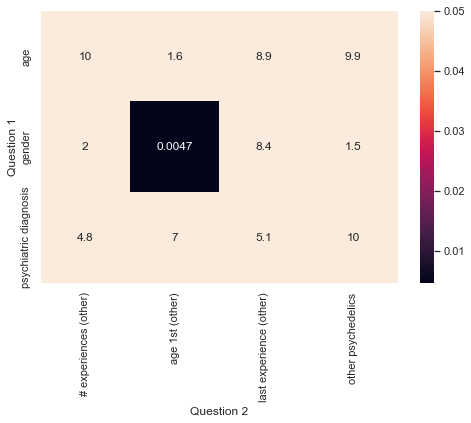

In [147]:
#testing correlations between demographics and background
bf_corr = (len(demo_q)*len(drugback_q+ayaback_q))/2
results_list = []

for i in demo_q:
    for j in drugback_q:
        
        #perform the test
        results = stat_test(df, df.columns[i], df.columns[j])
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': questions[i],  # Store column names, not indices
            'Question 2': questions[j],
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)

# Now you can perform pivoting and plotting
glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

#plot results
sns.heatmap(glue, vmax = 0.05, annot = True)

sns.set_theme(rc={'figure.figsize':(15,5)})
#plt.show()

#results_df

print(df_to_custom_latex_table(results_df)) #printing latex table for report

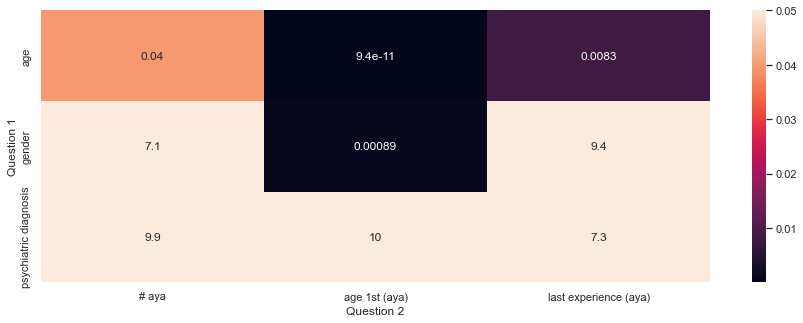

\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{age} & & & & & \\
    \hspace{3mm} age 1st (aya) & Chi-squared & 104.98 & 0.000 & 0.000 & 25 \\
    \hspace{3mm} # aya & Chi-squared & 67.97 & 0.004 & 0.040 & 40 \\
    \hspace{3mm} last experience (aya) & Chi-squared & 60.54 & 0.001 & 0.008 & 30 \\
    [1ex]
    \textbf{gender} & & & & & \\
    \hspace{3mm} age 1st (aya) & Chi-squared & 44.72 & 0.000 & 0.001 & 15 \\
    \hspace{3mm} # aya & Chi-squared & 20.28 & 0.681 & 7.149 & 24 \\
    \hspace{3mm} last experience (aya) & Chi-squared & 10.91 & 0.898 & 9.431 & 18 \\
    [1ex]
    \textbf{psychiatric diagnosis} & & & & & \\
    \hspace{3mm} age 1st (aya) & Chi-squared & 0.53 & 0.991 & 10.407 & 5 \\
    \hspace{3mm} # aya & Chi-squared & 

In [148]:
#testing correlations between demographics and aya
bf_corr = (len(demo_q)*len(drugback_q+ayaback_q))/2
results_list = []

for i in demo_q:
    for j in ayaback_q:
        
        #perform the test
        results = stat_test(df, df.columns[i], df.columns[j])
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': questions[i],  # Store column names, not indices
            'Question 2': questions[j],
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)

# Now you can perform pivoting and plotting
glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

#plot results
sns.heatmap(glue, vmax = 0.05, annot = True)

sns.set_theme(rc={'figure.figsize':(15,5)})
plt.show()

#results_df

print(df_to_custom_latex_table(results_df))

In [149]:
import itertools # Import itertools
#testing correlations between demographics and background
bf_corr = (len(drugback_q+ayaback_q)**2 - len(drugback_q+ayaback_q))/2
results_list = []

# Use itertools.combinations to get unique pairs (i, j) where i < j
for i, j in itertools.combinations(drugback_q+ayaback_q, 2):
    # The condition `if questions[i] != questions[j]:` is now implicitly handled
    # by itertools.combinations, as it never yields (x, x) pairs.

    # Perform the test
    results = stat_test(df, df.columns[i], df.columns[j])
    p = results['p_value']

    # Compute the corrected p value
    pcorr = p * bf_corr

    if pcorr < 0.05:
        sig = 'SIGNIFICANT'
    elif p < 0.05:
        sig = 'p sig'
    elif p >= 0.05:
        sig = 'not sig'

    # Append the results as a dictionary to the list
    results_list.append({
        'Question 1': questions[i],  # Store column names, not indices
        'Question 2': questions[j],
        'P-value': p,
        'Pcorr': pcorr,
        'Significance': sig,
        **results  # Unpack the dictionary
    })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)


#visualize
glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

sns.heatmap(glue, vmax = 0.05, annot = True, mask = trimask)

sns.set_theme(rc={'figure.figsize':(10,10)})
plt.show()

results_df
print(df_to_custom_latex_table(results_df))

ValueError: Mask must have the same shape as data.

In [ ]:
#testing for age of first experience and aya# corr with demographics
demo_q2 =  ['age_group','nb_aya','age_1psyche','age_1aya']

bf_corr = (len(demo_q2)*(2 + len(drugback_q+ayaback_q)))/2
results_list = []

for i in demo_q2:
    for j in [13,17] + drugback_q + ayaback_q:
        
        #perform the test
        results = stat_test(df, i, df.columns[j])
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': i,  # Store column names, not indices
            'Question 2': questions[j],
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)


glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

sns.heatmap(glue, vmax = 0.05, annot = True)

plt.show()


#print(df_to_custom_latex_table(results_df))

In [ ]:
bf_corr = (len(demo_q2)**2-len(demo_q2))/2
results_list = []

for i, j in itertools.combinations(demo_q2, 2):  
        #perform the test
        results = stat_test(df, i,j)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': i,  # Store column names, not indices
            'Question 2': j,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)

glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

trimask = np.tril(np.ones_like(glue, dtype=bool))
sns.heatmap(glue, vmax = 0.05, annot = True, mask = trimask)
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.show()
print(df_to_custom_latex_table(results_df))

### Voice hearing phenomenon


#### All participants

In [ ]:
#stats other 
all_prev, errors_all = get_percentages(df)

In [ ]:
#plotting results
    
# Create bar plot
labels = ['No psychedelics', 'During \n Psychedelics \n (not aya)', 'During \n Ayahuasca', 'After \n ayahuasca']
avh_stats = [39.51, 50.00, 78.95, 37.50]

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

ax.bar(x_pos, avh_stats, yerr= np.array(errors_all)*100, capsize=5, color=['skyblue', 'lightcoral', 'lightgreen', 'green'])
ax.set_xticks(x_pos, fontsize = 12)
ax.set_xticklabels(labels, fontsize = 12)


max_y = max(avh_stats) + max(errors_all)*100
add_significance_bar(ax, x_pos[2], x_pos[3], max_y*1.05, 1.8e-7, capsize = 1)
add_significance_bar(ax, x_pos[2], x_pos[1], max_y*1.15, 4.6e-4, capsize = 1)
add_significance_bar(ax, x_pos[2], x_pos[0], max_y*1.25, 3.5e-7, capsize = 1)


plt.xlabel('Context', fontsize = 14)
plt.ylabel('Percentage of people hearing voices (%)', fontsize = 14)
plt.title('Histogram of VH prevalence in different contexts', fontsize = 14)
plt.show()


In [ ]:
# Perform Cochran's Q test for repeated binary questions
# this is important to assess whether there is a difference between the different conditions, other post-hoc tests will test
# which conditions are actually different

# Select the relevant columns
columns_to_select = [23,24,37,38]
selected_df = df.iloc[:,columns_to_select]

# Map 'Yes'/'No' to 1/0
mapped_df = selected_df.applymap(lambda x: 1 if x == 'Yes' else 0)

# Convert to a NumPy array (required for statsmodels)
data_array = mapped_df.to_numpy()

# perform Cochran's Q test
result = sm.stats.cochrans_q(data_array)  # Get the Bunch object

q_statistic = result.statistic  # Access the statistic
p_value = result.pvalue      # Access the p-value

print("Cochran's Q statistic:", q_statistic) # the bigger q, the more diff across the group means for different questions
print("P-value:", p_value) # p < 0.05 means that H0 is rejected (H0 = no difference between groups) 


In [ ]:
dict_cols = {23: 'During \n Psychedelics \n (not aya)', 24: 'No psychedelics', 37: 'During \n Ayahuasca', 38: 'After \n ayahuasca'}

bf_corr = 6

results_list = []

# Post-hoc McNemar tests (example: comparing each pair of questions)

for i, j in itertools.combinations([23, 24, 37, 38], 2):
    
        #perform the McNemar test
        results = stat_test(df, df.columns[i], df.columns[j], paired= True)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': dict_cols[i],  # Store column names, not indices
            'Question 2': dict_cols[j],
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    

# Add a 'Significant' column:
results_df['Significant'] = results_df['Pcorr'] < 0.05

glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

sns.heatmap(glue, vmax = 0.05, annot = True)
sns.set_theme(rc={'figure.figsize':(8,5)})
lowercase_chi = "\u03C7"
plt.title(r'$P_{corr}$ '+ f'of McNemar tests for AVH', size = 14)
plt.show()

# Display the results in a table-like format:
results_df[results_df.Significance == 'SIGNIFICANT']
print(df_to_custom_latex_table(results_df)) #printing latex table for report

In [ ]:
# medical history: does that change anything to the VH results?
col = df.columns[17]
results_list = []
for i in [23,24,38,37]:        
    results = stat_test(df, col, df.columns[i])
    #compute the corrected p value
    pcorr = p*4

    if pcorr < 0.05:
        sig = 'SIGNIFICANT'
    elif p < 0.05:
        sig = 'p sig'
    elif p >= 0.05:
        sig = 'not sig'

    # Append the results as a dictionary to the list
    results_list.append({
        'Question 1': 'psych. diagnosis',  # Store column names, not indices
        'Question 2': dict_cols[i],
        'P-value': p,
        'Pcorr': pcorr,
        'Significance': sig,
        **results #unpack the dictionary
    })
# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df
print(df_to_custom_latex_table(results_df)) #printing latex table for report

#### Experts (>20 times)

In [ ]:
#select the people that have had more than 10 experiences

experts = df[(df[df.columns[29]] != '1-5') & (df[df.columns[29]] != '5-10') & (df[df.columns[29]] != '10-20')]# & (df[df.columns[29]] != '20-30')]
print(len(experts))

#stats 
experts_prev, experts_errors = get_percentages(experts)


In [ ]:
#look at frequency change for them
experts[experts.columns[[39,88]]]

In [ ]:
results_list = []  # List to store the results
bf_corr = 6
for i, j in itertools.combinations([23, 24, 37, 38], 2):
        #perform the McNemar test
        results = stat_test(experts, experts.columns[i], experts.columns[j], paired= True)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': questions[i],  # Store column names, not indices
            'Question 2': questions[j],
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    
# Add a 'Significant' column:
results_df['Significant'] = results_df['Pcorr'] <= 0.05

glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

sns.heatmap(glue, vmax = 0.05, annot = True)
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.show()

#results_df

print(df_to_custom_latex_table(results_df)) #printing latex table for report

In [ ]:
labels = ['No psychedelics', 'During \n Psychedelics \n (not aya)', 'During \n Ayahuasca', 'After \n ayahuasca']

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

ax.bar(x_pos, experts_prev, yerr= np.array(experts_errors), capsize=5, color=['skyblue', 'lightcoral', 'lightgreen', 'green'])
ax.set_xticks(x_pos, fontsize = 12)
ax.set_xticklabels(labels, fontsize = 12)


max_y = max(experts_prev) + max(experts_errors)
add_significance_bar(ax, x_pos[2], x_pos[3], max_y*1.05, 1, color = 'forestgreen')
add_significance_bar(ax, x_pos[2], x_pos[1], max_y*1.15, 1, color = 'forestgreen')
add_significance_bar(ax, x_pos[2], x_pos[0], max_y*1.25, 1, color = 'forestgreen')


plt.xlabel('Context', fontsize = 14)
plt.ylabel('Proportion of people hearing voices', fontsize = 14)
plt.title('Histogram of VH prevalence in different contexts', fontsize = 14)
plt.show()


In [ ]:
# plotting them both together
labels = ['No psychedelics', 'During \n Psychedelics \n (not aya)', 'During \n Ayahuasca', 'After \n ayahuasca']
avh_stats_experts = [72.73, 68.18, 90.91, 47.62]

x_pos = np.arange(len(labels))
width = 0.35  # Width of the bars

fig, ax = plt.subplots()

# Bars for the first group
rects1 = ax.bar(x_pos - width/2, avh_stats_experts, width, yerr=np.array(experts_errors)*100, capsize=5, 
                color='forestgreen', label='> 30 experiences')

# Bars for the second group, offset to the right
rects2 = ax.bar(x_pos + width/2, avh_stats, width, yerr=np.array(errors_all)*100, capsize=5,
                color='royalblue', label='All')


ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=12)

max_y = max(max(avh_stats_experts), max(avh_stats)) + max(experts_errors)*100
add_significance_bar(ax, x_pos[2]+width, x_pos[3]+width, max_y*1.05, 0.0001, color = 'royalblue',capsize= 1.1)
add_significance_bar(ax, x_pos[2]+width, x_pos[1]+width, max_y*1.15,  0.0001, color = 'royalblue',capsize= 1.1)
add_significance_bar(ax, x_pos[2]+width, x_pos[0]+width, max_y*1.25,  0.0001, color = 'royalblue',capsize= 1.1)

plt.xlabel('Context', fontsize=14)
plt.ylabel('Percentage of people hearing voices (%)', fontsize=14)
plt.title('Histogram of VH prevalence in different contexts', fontsize=14)
plt.legend()  # Add a legend
plt.show()

#### Others

In [ ]:
others =  df.drop(experts.index)
print(len(others))
others_prev, others_errors = get_percentages(others)

In [ ]:
others[others.columns[[39,88]]]

In [ ]:
# between the different contexts for this group?

# what about the subgroup of ppl that have taken ayahuasca more than 20 times?
results_list = []  # List to store the results
for i, j in itertools.combinations([23, 24, 37, 38], 2):
        #perform the McNemar test
        results = stat_test(others, others.columns[i], others.columns[j], paired= True)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': questions[i],  # Store column names, not indices
            'Question 2': questions[j],
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    
# Add a 'Significant' column:
results_df['Significant'] = results_df['Pcorr'] <= 0.05

glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")
sns.heatmap(glue, vmax = 0.05, annot = True)
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.show()
 
#results_df
print(df_to_custom_latex_table(results_df)) #printing latex table 

#### Others vs Experts

In [ ]:
others =  df.drop(experts.index)

In [ ]:
#exploring how the sig changes depending on the threshold
experts1 =  df[(df[df.columns[29]] != '1-5')]
experts2 =  df[(df[df.columns[29]] != '1-5') & (df[df.columns[29]] != '5-10')]
experts3 =  df[(df[df.columns[29]] != '1-5') & (df[df.columns[29]] != '5-10') & (df[df.columns[29]] != '10-20')] 
experts4 =  df[(df[df.columns[29]] != '1-5') & (df[df.columns[29]] != '5-10') & (df[df.columns[29]] != '10-20') & (df[df.columns[29]] != '20-30')] 
experts5 =  df[(df[df.columns[29]] != '1-5') & (df[df.columns[29]] != '5-10') & (df[df.columns[29]] != '10-20') & (df[df.columns[29]] != '20-30') & (df[df.columns[29]] != '30-40')] 

results_list = []

for i, question in enumerate([24, 23, 37, 38]):

    for t, exp in enumerate([experts1, experts2, experts3, experts4, experts5]):
    
        others = df.drop(exp.index)
        
        #to store the counts
        experts_counts_y = []
        experts_counts_n = []
        all_counts_y = []
        all_counts_n = []

        # Correct calculation of "Yes" and "No" counts (handles missing values)
        experts_counts_y.append(exp[exp.columns[question]].value_counts().get('Yes', 0))
        experts_counts_n.append(len(exp[exp.columns[question]]) - experts_counts_y[-1])  # Correct

        all_counts_y.append(others[others.columns[question]].value_counts().get('Yes', 0))
        all_counts_n.append(len(others[others.columns[question]]) - all_counts_y[-1])  # Correct
       
        #compute the stat    
        for j in range(len(experts_counts_y)):
            observed = np.array([ [experts_counts_y[j], experts_counts_n[j]],
                                  [all_counts_y[j]    , all_counts_n[j]]     ])
        
        # Chi-Square Test
        chi2, p, dof, expected = chi2_contingency(observed) #normal chi-squared
        
        expected = chi2_contingency(observed)[3]
        if np.any(expected < 5):
            warning_message = f"Chi-squared test might be unreliable for {question} and {t} due to small expected cell counts. Consider simulation."
        else:
            warning_message = None

        if p < 0.05:
            sig = 'sig'
        else:
            sig = ' '
        
        #store results
        results_list.append({
            'Question 1': questions[question],  # Store column names, not indices
            'Question 2': (t+1), #threshold
            'P-value': p,
            'Pcorr': p*4,
            'dof': dof,
            'statistic': chi2,
            'test_name': 'chi-squared',
            'npart': len(exp[exp.columns[question]]),
            'error': warning_message,
            'sig': sig,
            'cont': observed
        })
# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    

results_df
print(df_to_custom_latex_table(results_df)) #printing latex table

In [ ]:
# plotting everything together
labels = ['No psychedelics', 'Other psychedelics', 'During ayahuasca', 'Post ayahuasca']


x_pos = np.arange(len(labels))
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize = (10,6))

# Bars for the first group (experts)
rects1 = ax.bar(x_pos - width, experts_prev, width, yerr = experts_errors, capsize=5,
                color='forestgreen', label='> 20 experiences')

# Bars for the second group, offset to the right (all)
rects2 = ax.bar(x_pos, all_prev, width, capsize=5,  yerr = errors_all,
                color='royalblue', label='All')

# Bars for the second group, offset to the right (less than N exp)
rects2 = ax.bar(x_pos + width, others_prev, width, capsize=5, yerr = others_errors,
                color='indianred', label='≤ 20 experiences')


ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=12)

max_y = 0.90

# Set y-axis ticks and labels as percentages
yticks = np.arange(0, 1.1, 0.1)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{y * 100:.0f}%' for y in yticks], fontsize=12)


#between the conditions
add_significance_bar(ax, x_pos[2], x_pos[3], max_y*1.01, 0.0001, color = 'royalblue', capsize = 0.01)
add_significance_bar(ax, x_pos[2], x_pos[1], max_y*1.20,  0.0001, color = 'royalblue', capsize = 0.01)
add_significance_bar(ax, x_pos[2], x_pos[0], max_y*1.37,  0.0001, color = 'royalblue', capsize = 0.01)

#between the conditions
add_significance_bar(ax, x_pos[2]+width, x_pos[3]+width, max_y*1.01-0.07, 0.0001, color = 'indianred', capsize = 0.01)
add_significance_bar(ax, x_pos[2]+width, x_pos[1]+width, max_y*1.20-0.07,  0.0001, color = 'indianred', capsize = 0.01)
add_significance_bar(ax, x_pos[2]+width, x_pos[0]+width, max_y*1.37-0.07,  0.0001, color = 'indianred', capsize = 0.01)

#between the group (less and more than 30 experiences) within conditions
add_significance_bar(ax, x_pos[0] - width, x_pos[0] + width, max_y*1.01,  0.002, color = 'black', capsize = 0.01)
add_significance_bar(ax, x_pos[1] - width, x_pos[1] + width, max_y*1.01,  0.03, color = 'black', capsize = 0.01)


# Remove background grid lines
#plt.grid(False, axis='y') # Remove horizontal grid lines (behind the bars)
plt.grid(False, axis='x') # Remove vertical grid lines

# Add the horizontal bar and "baseline" text
sec = ax.secondary_xaxis(location=0)
sec.set_xticks([0.5], labels=[' \n \n Baseline'],size= 12)
sec.tick_params('x', length=0, )

plt.xlabel(' \n \n Context', fontsize=14)
plt.ylabel('% of people hearing voices', fontsize=14, labelpad = 5,y=0.4)
plt.title('VH prevalence in different contexts', fontsize=14)
plt.legend(loc = [0.75,0.8])  # Add a legend

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data = results_df, x='Threshold', y='Pvalue', hue='Question')
plt.xticks([1, 2, 3, 4, 5], ['5', '10', '20', '30', '40'])  # Corrected xticks
plt.xlabel('Threshold')
plt.ylabel('P-value')
plt.yscale('log')
plt.title('P-value vs. Threshold by Question')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data = results_df, x='Threshold', y='chi2', hue='Question')
plt.xticks([1, 2, 3, 4, 5], ['5', '10', '20', '30', '40'])  # Corrected xticks
plt.xlabel('Threshold')
plt.ylabel('Chi2')
plt.title('Chi2 vs. Threshold by Question')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data = results_df, x='Threshold', y='dof', hue='Question')
plt.xticks([1, 2, 3, 4, 5], ['5', '10', '20', '30', '40'])  # Corrected xticks
plt.xlabel('Threshold')
plt.ylabel('Dof')
plt.title('Dof vs. Threshold by Question')
plt.tight_layout()
plt.show()


#### can we explain this with demographic vars?

In [150]:
demo_q2

['age_group', 'nb_aya', 'age_1psyche', 'age_1aya']

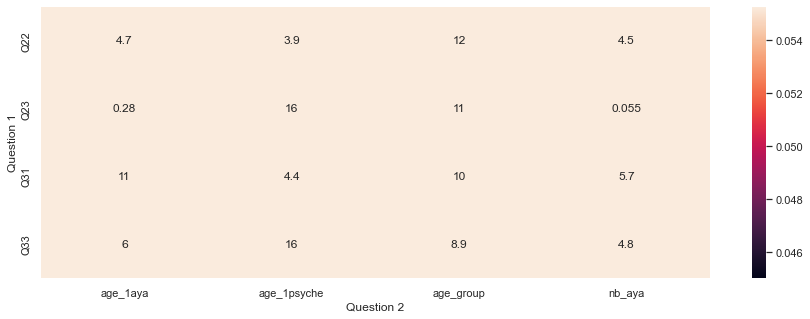

\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{Q22} & & & & & \\
    \hspace{3mm} age_group & Chi-squared & 1.19 & 0.756 & 12.091 & 3 \\
    \hspace{3mm} nb_aya & Chi-squared & 5.08 & 0.279 & 4.471 & 4 \\
    \hspace{3mm} age_1psyche & Chi-squared & 1.35 & 0.246 & 3.932 & 1 \\
    \hspace{3mm} age_1aya & Chi-squared & 3.73 & 0.292 & 4.668 & 3 \\
    [1ex]
    \textbf{Q23} & & & & & \\
    \hspace{3mm} age_group & Chi-squared & 1.39 & 0.707 & 11.319 & 3 \\
    \hspace{3mm} nb_aya & Chi-squared & 15.70 & 0.003 & 0.055 & 4 \\
    \hspace{3mm} age_1psyche & Chi-squared & 0.00 & 1.000 & 16.000 & 1 \\
    \hspace{3mm} age_1aya & Chi-squared & 8.11 & 0.017 & 0.277 & 2 \\
    [1ex]
    \textbf{Q31} & & & & & \\
    \hspace{3mm} age_group & Ch

In [151]:
#can we explain VH through other variables
bf_corr = (len(avh_q)*len(demo_q2))
results_list = []

for i in avh_q:
    for j in demo_q2:
        #perform chi-suared
        results = stat_test(df, df.columns[i],j)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': df.columns[i],  # Store column names, not indices
            'Question 2': j,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    


glue = results_df.pivot(index="Question 1", columns="Question 2", values="Pcorr")

#trimask = np.tril(np.ones_like(glue, dtype=bool))
sns.heatmap(glue, vmax = 0.05, annot = True)
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.show()

#results_df
print(df_to_custom_latex_table(results_df)) #printing latex table for report

## Context and control 
Can contextual factors (music, people’s presence, intention..) shape these features?
How does the voice-hearing experience change from during to after the acute experience?
  

### Reason for doing ayahuasca

In [152]:
for col in ['31_Other','31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:
    df[col] = df[col].map({1:'Yes', 0:'No'})

In [156]:
# family of test: comparing AVH with intention for ayahuasca
results_list = []
bf_corr = 25

for i in [23,24,37,38]:
    for j in ['31_Other','31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:
        #perform the McNemar test
        results = stat_test(df, df.columns[i], j)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': questions[i],  # Store column names, not indices
            'Question 2': j,
            'Pcorr': pcorr,
            'P-value':p,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    
results_df
#print(df_to_custom_latex_table(results_df)) #printing latex table for report

,Question 1,Question 2,Pcorr,P-value,Significance,test_name,p_value,statistic,effect_size,warning,dof
0,AVH during (other),31_Other,25.000000,1.000000,not sig,Fisher's exact,1.000000,NaN,0.647059,None,NaN
1,AVH during (other),31_Recreational,25.000000,1.000000,not sig,Chi-squared,1.000000,0.000000,Q22 No 0.0 Yes 0.0 dtype: float64,None,1.0
2,AVH during (other),31_Religion,0.187415,0.007497,p sig,Chi-squared,0.007497,7.149950,Q22 No 0.445657 Yes 0.445657 dtype: flo...,None,1.0
3,AVH during (other),31_Ritual,13.500686,0.540027,not sig,Chi-squared,0.540027,0.375489,Q22 No 0.102129 Yes 0.102129 dtype: flo...,None,1.0
4,AVH during (other),31_Therapeutic,20.064684,0.802587,not sig,Chi-squared,0.802587,0.062500,Q22 No 0.041667 Yes 0.041667 dtype: flo...,None,1.0
5,AVH (none),31_Other,25.000000,1.000000,not sig,Fisher's exact,1.000000,NaN,1.022222,None,NaN
6,AVH (none),31_Recreational,18.885301,0.755412,not sig,Fisher's exact,0.755412,NaN,0.732143,None,NaN
7,AVH (none),31_Religion,0.032607,0.001304,SIGNIFICANT,Chi-squared,0.001304,10.336467,Q23 No 0.459291 Yes 0.568344 dtype: flo...,None,1.0
8,AVH (none),31_Ritual,13.387016,0.535481,not sig,Chi-squared,0.535481,0.383980,Q23 No 0.088523 Yes 0.109542 dtype: flo...,None,1.0
9,AVH (none),31_Therapeutic,15.522637,0.620905,not sig,Chi-squared,0.620905,0.244597,Q23 No 0.070652 Yes 0.087428 dtype: flo...,None,1.0


In [154]:
# comparing subset of ppl who answered religion and other's AVH on ayahuasca
group1 = df[df['31_Religion'] == 1]
group2 = df[df['31_Religion'] == 0]

col = 24

#comparing the two groups' AVH proportion during ayahuasca 
contingency =[ [len(group1[group1.iloc[:,col] == 'Yes']),len(group1[group1.iloc[:,col] == 'No'])],
               [len(group2[group2.iloc[:,col] == 'Yes']),len(group2[group2.iloc[:,col] == 'No'])] ] 
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)
print(chi2,p,dof)




[[0, 0], [0, 0]]
nan nan 1


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\contingency.py:128: RuntimeWarning: invalid value encountered in true_divide
  expected = reduce(np.multiply, margsums) / observed.sum() ** (d - 1)


In [155]:
# does the intention correlate with background variables?
results_list = []
for i in ['age_group', 'nb_aya', 'age_1psyche', 'age_1aya']:
    for j in ['31_Other','31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:
        
        #perform the McNemar test
        results = stat_test(df, i,j)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': i,  # Store column names, not indices
            'Question 2': j,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANCE']

,Question 1,Question 2,P-value,Pcorr,Significance,test_name,p_value,statistic,dof,effect_size,warning


In [207]:
#did the people who answer yes at religion answered yes at another category?
religion_subset = df[df['31_Religion'] == 'Yes']
 
for col in ['31_Other','31_Recreational','31_Ritual', '31_Therapeutic']:
    print(col)
    print(religion_subset[col].value_counts())

31_Other
No     16
Yes     3
Name: 31_Other, dtype: int64
31_Recreational
No     15
Yes     4
Name: 31_Recreational, dtype: int64
31_Ritual
Yes    19
Name: 31_Ritual, dtype: int64
31_Therapeutic
Yes    10
No      9
Name: 31_Therapeutic, dtype: int64


#### effect on control during ayahusca

In [ ]:
# 1. Convert all relevant columns to 'Yes'/'No' strings:
cols_to_convert = ['31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']  # List ALL relevant columns

for col in cols_to_convert:
    if df[col].dtype == 'int': # Check if the column is of integer type
        df[col] = df[col].map({1: 'Yes', 0: 'No'}).astype(str) # Map the integer values to strings and then change the type of the column to string
    elif df[col].dtype == 'bool': # Check if the column is of boolean type
        df[col] = df[col].map({True: 'Yes', False: 'No'}).astype(str) # Map the boolean values to strings and then change the type of the column to string
    elif df[col].dtype != 'object': # Check if the column is not of object type
        try:
            df[col] = df[col].astype(str) # Try to convert to string
        except:
            print(f"Column {col} could not be converted to string")

In [ ]:
# BEFORE:
# family of tests: before ayahusca; control vs intention
print('BEFORE')
# does it change the control over features given the intention, age of first time taking ayahuasca or other psychedelics and number of times taking ayahuasca
question = ['frequency', 'intensity', 'presence/absence', 'content', 'emotional tone']

results_list = []
bf_corr = 20

for j in ['31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:
    for i in [122, 123, 121, 124, 125]:
        
        #perform the McNemar test
        results = stat_test(df, df.columns[i],j)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': df.columns[i],  # Store column names, not indices
            'Question 2': j,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df

In [ ]:
# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)    
results_list = []

#After
# family of tests: before ayahusca; control vs intention

print('AFTER')
for j in ['31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:  # Your desired names 
    for i in [72,73,74,75,76]:
        
        results = stat_test(df, df.columns[i],j)
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': df.columns[i],  # Store column names, not indices
            'Question 2': j,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df


#### effect on pheno during/after ayahuasca

In [ ]:
#pheno --> nothing is sig so i didn't apply the correction
#context during
results_list = []
bf_corr = 9*4

for i in ['31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:  # Your desired names 
    for j, item in enumerate(['emotional','context', 'location', 'facilitators', 'other ppl actions', 'music', 'sensorial context', 'own state of mind','recent events']):
   
        results = stat_test(df, i, df.columns[j+101])
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': i,  # Store column names, not indices
            'Question 2': item,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANT']

In [ ]:
# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_list = []
#context after
for i in ['31_Recreational', '31_Religion', '31_Ritual', '31_Therapeutic']:  # Your desired names 
    for j, item in enumerate(['emotional','context', 'location', 'facilitators', 'other ppl actions', 'music', 'sensorial context', 'own state of mind','recent events']):

        results = stat_test(df, i, df.columns[j+52])
        p = results['p_value']
        
        #compute the corrected p value
        pcorr = p*bf_corr
        
        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'
        
        # Append the results as a dictionary to the list
        results_list.append({
            'Question 1': i,  # Store column names, not indices
            'Question 2': item,
            'P-value': p,
            'Pcorr': pcorr,
            'Significance': sig,
            **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df


### Pleasantness

In [ ]:
#change the responses into two categories to make it easier to get a result
df.iloc[:, 101] = df.iloc[:,101].map(({'Mostly pleasant': 'Pleasant', 'Neutral': np.nan, 'Both pleasant and unpleasant': 'Unpleasant',
                    'Hard to say' : np.nan}))

df.iloc[:, 52] = df.iloc[:, 52].map(({'Mostly pleasant': 'Pleasant', 'Neutral': np.nan, 'Both pleasant and unpleasant': 'Unpleasant',
                    'Hard to say' : np.nan}))


In [ ]:
#assert diff, using 
contingency_table = pd.crosstab(df.iloc[:,52], df.iloc[:,101])
print(contingency_table)
results =run_mcnemar_test(contingency_table)
print(p) #still not sig

### Phenomenology

In [ ]:
#check whether interaction and emotional tonality have changed
#interaction during: 100, after: 51

### Context

In [ ]:
#emotional tonality #NEED TO DO THIS WITH CHI SQUARED

In [157]:
df.iloc[13,106] = np.nan #this person answered both yes and no, so we remove this data
df.iloc[13,57] = np.nan #this person answered both yes and no, so we remove this data

print(df.iloc[13,106])

nan


In [158]:
df.iloc[:,60].dropna()


19     No
29    Yes
59    Yes
63    Yes
71     No
Name: Q136#1_7, dtype: object

In [175]:
# family of test: change in the control over different features but every test is performed only once so no correction
j_dict = {53:102,54:103,55:104,56:105,57:106,58:107,59:108,60:109}
results_list = []

for i in [53]:#,54,55,58,59,60]:
    j = j_dict[i]
    print(i,j)
    try:
        results = stat_test(df, df.columns[i], df.columns[j], paired=True)
        p = results['p_value']
    
        print(p) 
        #compute the corrected p value
        pcorr = p*1

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

    except ValueError as e:
        print(f"Error for {q1_col_name} and {q2_col_name}: {e}")
        sig = 'Error (ValueError)' # More specific error message
        test_results_dict['test_name'] = 'Error' # Indicate error in test_name
        # p, pcorr, statistic, dof remain np.nan from initialization

    except Exception as e: # Catch any other unexpected errors
        print(f"An unexpected error occurred for {q1_col_name} and {q2_col_name}: {e}")
        sig = 'Error (Unexpected)'
        test_results_dict['test_name'] = 'Error'
        # p, pcorr, statistic, dof remain np.nan from initialization

    # --- Append the results (or error placeholders) for EVERY pair after handling ---
    results_list.append({
        'Question 1': q1_col_name,
        'Question 2': q2_col_name,
        'P-value': p,
        'Pcorr': pcorr,
        'Significance': sig,
        **test_results_dict # Unpack the dictionary (either real results or placeholders)
    })


# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df
#print(df_to_custom_latex_table(results_df)) #printing latex table for report

53 102
0.109375


,Question 1,Question 2,P-value,Pcorr,Significance,test_name,statistic,dof
0,Q136#1_8,Q69#1_8,0.109375,0.109375,not sig,Error,NaN,NaN


In [178]:
# family of test: change in the control over different features during ayahuasca but every test is performed only once so no correction
j_dict = {53:102,54:103,55:104,56:105,57:106,58:107,59:108,60:109}
print('before')
results_list = []
bf_corr = 9
#during ayahusca
for demo in [12,13,17,19,21,22,28,29,30]:
    for i in [53]: #,54,55,56,57,58,59,60]: these are useful only if there is a change in control in the first place

        j = j_dict[i]
        
        results = stat_test(df, df.columns[demo], df.columns[j])  # Or paired=False as needed
        p = results['p_value']
                # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*bf_corr

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                'Question 1': questions[demo],  # Store column names, not indices
                'Question 2': j,
                'P-value': p,
                'Pcorr': pcorr,
                'Significance': sig,
                **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df_before = pd.DataFrame(results_list)  
#results_df[results_df.Significance == 'SIGNIFICANT']
results_df_before

print(df_to_custom_latex_table(results_df_before)) #printing latex table for report

before
\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{age} & & & & & \\
    \hspace{3mm} 102 & Chi-squared & 7.02 & 0.219 & 1.975 & 5 \\
    [1ex]
    \textbf{gender} & & & & & \\
    \hspace{3mm} 102 & Chi-squared & 3.82 & 0.282 & 2.539 & 3 \\
    [1ex]
    \textbf{psychiatric diagnosis} & & & & & \\
    \hspace{3mm} 102 & Fisher's exact & - & 0.734 & 6.602 & - \\
    [1ex]
    \textbf{other psychedelics} & & & & & \\
    \hspace{3mm} 102 & Fisher's exact & - & 0.476 & 4.285 & - \\
    [1ex]
    \textbf{# experiences (other)} & & & & & \\
    \hspace{3mm} 102 & Chi-squared & 5.62 & 0.689 & 6.205 & 8 \\
    [1ex]
    \textbf{last experience (other)} & & & & & \\
    \hspace{3mm} 102 & Chi-squared & 8.84 & 0.183 & 1.647 & 6 \\
    [1ex

In [177]:
#after ayahuasca
print('after')

results_list = []
bf_corr = 9

for demo in [12,13,17,19,21,22,28,29,30]:
    for i in [53]:
        
        results = stat_test(df, df.columns[demo], df.columns[i])  # Or paired=False as needed
        p = results['p_value']
                # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*bf_corr

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                'Question 1': questions[demo],  # Store column names, not indices
                'Question 2': i,
                'P-value': p,
                'Pcorr': pcorr,
                'Significance': sig,
                **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df_after = pd.DataFrame(results_list)  
results_df
print(df_to_custom_latex_table(results_df)) #printing latex table for report

after
\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{Q136#1_8} & & & & & \\
    \hspace{3mm} Q69#1_8 & Error & - & 0.109 & 0.109 & - \\
    [1ex]
    \bottomrule
    \end{tabular}
    \caption{\textbf{Descriptive statistics of the voice phenomenology during and after ayahuasca.}}
    \endgroup
\end{table}


### control

In [179]:
# family of test: change in the control over different features but every test is performed only once so no correction
j_dict = {72:122,73:123,74:121,75:124,76:125,77:126}
results_list = []
bf_corr = 1
for i in [72,73,74,75,76,77]:
    j = j_dict[i]
    print(df.columns[j])
    results = stat_test(df, df.columns[i], df.columns[j], paired = True)
    p = results['p_value']
            # ... (rest of processing)


    #compute the corrected p value
    pcorr = p*bf_corr

    if pcorr < 0.05:
        sig = 'SIGNIFICANT'
    elif p < 0.05:
        sig = 'p sig'
    elif p >= 0.05:
        sig = 'not sig'

    # Append the results as a dictionary to the list
    results_list.append({
                'Question 1': df.columns[i],  # Store column names, not indices
                'Question 2': df.columns[j],
                'P-value': p,
                'Pcorr': pcorr,
                'Significance': sig,
                **results #unpack the dictionary
    })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df
print(df_to_custom_latex_table(results_df)) #printing latex table for report

Q66#1_2
Q66#1_3
Q66#1_1
Q66#1_4
Q66#1_5
Q66#1_6
\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{Q46#1_1} & & & & & \\
    \hspace{3mm} Q66#1_2 & McNemar's & 0.00 & 0.062 & 0.062 & - \\
    [1ex]
    \textbf{Q46#1_2} & & & & & \\
    \hspace{3mm} Q66#1_3 & McNemar's & 0.00 & 1.000 & 1.000 & - \\
    [1ex]
    \textbf{Q46#1_3} & & & & & \\
    \hspace{3mm} Q66#1_1 & McNemar's & 0.00 & 0.500 & 0.500 & - \\
    [1ex]
    \textbf{Q46#1_4} & & & & & \\
    \hspace{3mm} Q66#1_4 & McNemar's & 1.00 & 0.625 & 0.625 & - \\
    [1ex]
    \textbf{Q46#1_5} & & & & & \\
    \hspace{3mm} Q66#1_5 & McNemar's & 0.00 & 1.000 & 1.000 & - \\
    [1ex]
    \textbf{Q46#1_6} & & & & & \\
    \hspace{3mm} Q66#1_6 & McNemar's & 0.00 & 1.000 & 1.000 & - \\
    [

In [187]:
# control over features given the intention, age of first time taking ayahuasca or other psychedelics and number of times taking ayahuasca

#DURING
results_list = []
for col in ['age_group','nb_aya','age_1psyche','age_1aya']:
    for i in [72,73,74,75,76,77]:
        j = j_dict[i]
        results = stat_test(df, col, df.columns[j])
        p = results['p_value']
        # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*6

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                    'Question 1': col,  # Store column names, not indices
                    'Question 2': df.columns[j],
                    'P-value': p,
                    'Pcorr': pcorr,
                    'Significance': sig,
                    **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANT']
print(df_to_custom_latex_table(results_df)) #printing latex table for report

\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{age_group} & & & & & \\
    \hspace{3mm} Q66#1_2 & Chi-squared & 0.60 & 0.896 & 5.376 & 3 \\
    \hspace{3mm} Q66#1_3 & Chi-squared & 1.05 & 0.789 & 4.733 & 3 \\
    \hspace{3mm} Q66#1_1 & Chi-squared & 0.71 & 0.872 & 5.231 & 3 \\
    \hspace{3mm} Q66#1_4 & Chi-squared & 0.71 & 0.872 & 5.231 & 3 \\
    \hspace{3mm} Q66#1_5 & Chi-squared & 0.51 & 0.916 & 5.494 & 3 \\
    \hspace{3mm} Q66#1_6 & Chi-squared & 5.78 & 0.056 & 0.334 & 2 \\
    [1ex]
    \textbf{nb_aya} & & & & & \\
    \hspace{3mm} Q66#1_2 & Chi-squared & 3.67 & 0.299 & 1.794 & 3 \\
    \hspace{3mm} Q66#1_3 & Chi-squared & 3.81 & 0.283 & 1.696 & 3 \\
    \hspace{3mm} Q66#1_1 & Chi-squared & 4.07 & 0.254 & 1.526 & 3 \\
    \hspa

In [191]:
#after
results_list = []

for demo in ayaback_q + drugback_q:
    for i in [72,73,74,75,76,77]:
           
        results = stat_test(df, df.columns[i], df.columns[demo])
        p = results['p_value']
                # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*6

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                    'Question 1': i,  # Store column names, not indices
                    'Question 2': questions[demo],
                    'P-value': p,
                    'Pcorr': pcorr,
                    'Significance': sig,
                    **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANT']
#print(df_to_custom_latex_table(results_df)) #printing latex table for report

,Question 1,Question 2,P-value,Pcorr,Significance,test_name,p_value,statistic,dof,effect_size,warning
7,73,# aya,0.008187,0.049124,SIGNIFICANT,Chi-squared,0.008187,19.0,7.0,Q46#1_2 No 1.125463 Yes 2.179449 dtype:...,Chi-squared test might be unreliable for Q46#1...


In [192]:
results_list = []
for col in ['age_group','nb_aya','age_1psyche','age_1aya']:
    for i in [72,73,74,75,76,77]:
        
        results = stat_test(df, col, df.columns[i])
        p = results['p_value']
        # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*bf_corr

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                    'Question 1': col,  # Store column names, not indices
                    'Question 2': i,
                    'P-value': p,
                    'Pcorr': pcorr,
                    'Significance': sig,
                    **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANT']
#print(df_to_custom_latex_table(results_df)) #printing latex table for report

,Question 1,Question 2,P-value,Pcorr,Significance,test_name,p_value,statistic,dof,effect_size,warning
7,nb_aya,73,0.001826,0.001826,SIGNIFICANT,Chi-squared,0.001826,14.988889,3.0,nb_aya few 1.368799 many ...,Chi-squared test might be unreliable for nb_ay...


In [62]:
list(df.iloc[:, 127].dropna())

['I did not try to control them, and I have heard voices very rarely at all',
 'This was ‘lack of control’ not in the slightest disconcerting and was welcomed no matter what it had to say or how it was said - hearing the voice of The Mother has always been considered a gift ',
 'I could choose what I paid attention to and had dialogue with',
 "For the presence / absence. It's more like if I don't make attention to that, or I don't want, I can cut. Or if something stronger happened. It'smore  like I had to listen. If you don't want to listen, you don't listen. Must be open to that.",
 'I interact with these voices ',
 'For me... vision is primary I can see in a visionary way easily. When I hear is a visionary way its usually when the medicine is very strong.',
 "Is often possible to skip if it's too difficult but i try not to abuse in it",
 'it s just like an improvising guest you ve accepted at you your door.',
 'Famle',
 'In order to identify them individually, I would call them forwa

In [63]:
#after
print('after')
results_list = []
j_dict = {72:122,73:123,74:121,75:124,76:125,77:126}
results_list
bf_corr = 6*9
for demo in [12,13,17,19,21,22,28,29,30]:
    for j in [72,73,74,75,76,77]:
        
        results = stat_test(df, col, df.columns[j])
        p = results['p_value']
        # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*bf_corr

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                    'Question 1': col,  # Store column names, not indices
                    'Question 2': j,
                    'P-value': p,
                    'Pcorr': pcorr,
                    'Significance': sig,
                    **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANT']

after


,Question 1,Question 2,P-value,Pcorr,Significance,test_name,p_value,statistic,dof,effect_size,warning


In [64]:
results_list = []
for col in ['age_group','nb_aya','age_1psyche','age_1aya']:
    for i in [72,73,74,75,76,77]:
        j = j_dict[i]
        
        results = stat_test(df, col, df.columns[j])
        p = results['p_value']
        # ... (rest of processing)


        #compute the corrected p value
        pcorr = p*bf_corr

        if pcorr < 0.05:
            sig = 'SIGNIFICANT'
        elif p < 0.05:
            sig = 'p sig'
        elif p >= 0.05:
            sig = 'not sig'

        # Append the results as a dictionary to the list
        results_list.append({
                    'Question 1': col,  # Store column names, not indices
                    'Question 2': j,
                    'P-value': p,
                    'Pcorr': pcorr,
                    'Significance': sig,
                    **results #unpack the dictionary
        })

# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)  
results_df[results_df.Significance == 'SIGNIFICANT']

,Question 1,Question 2,P-value,Pcorr,Significance,test_name,p_value,statistic,dof,effect_size,warning


# Scales Scores

In [244]:
# import dataset containing score
df_scales = pd.read_csv('clean_dataset_scales.csv', encoding = 'UTF-8')

#keep only people
rows_to_keep = df_scales.iloc[:, 135:178].dropna(how='any').index
df_scales = df_scales.loc[rows_to_keep]
len(df_scales)

#categorise ppl into more and less than 28
df_scales['TAS_SCORE_BINARY'] = np.where(df_scales['TAS_SCORE'] < 28.71, 0, 1)


for col in [24,37]:
    df_scales.iloc[:,col] = df_scales.iloc[:,col].map(({'Never': 'No', 'A few times': 'Yes', 'Many times': 'Yes',
                    'Once': 'Yes', 'Always' : 'Yes'}))

### TAS

In [245]:
df_scales['TAS_SCORE'].describe()

count    59.000000
mean     20.847458
std       7.080360
min       5.000000
25%      15.500000
50%      22.000000
75%      25.000000
max      34.000000
Name: TAS_SCORE, dtype: float64

### Checking the religious subset

In [270]:
#checking the religious subset
rel_scales = df_scales[df_scales.index.isin(religion_subset.index)]

#check the scores
rel_scales['HS_SCORE'].describe()

count     9.000000
mean     14.222222
std       4.085884
min       9.000000
25%      12.000000
50%      14.000000
75%      16.000000
max      22.000000
Name: HS_SCORE, dtype: float64

In [266]:
#test whether TAS correlates with AVH
#scales = df_scales
scales= rel_scales

results_list = []
# test whether TAS scores correlates with other demographic variables, or drung background
for i in [23,24,37,38]+demo_q+ ayaback_q + drugback_q:
    contingency_table = pd.crosstab(scales['TAS_SCORE_BINARY'], scales.iloc[:,i])
    #print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p <= 0.05:
        print('SIGNIFICANT')
    else : print(p)
    results_list.append({
                    'Question 1': 'TAS_SCORE_BINARY',  # Store column names, not indices
                    'Question 2': questions[i],
                    'P-value': p,
                    'Pcorr': p*4,
                    'Significance': sig,
                    'dof':  dof,
                    'statistic' : chi2,
                    **results #unpack the dictionary
        })
# Create the DataFrame *outside* the loop
results_df = pd.DataFrame(results_list)

print(df_to_custom_latex_table(results_df))

1.0
1.0
1.0
0.7768140041554821
0.7768140041554821
1.0
1.0
0.4774548329166959
0.7815109419332178
0.19839515931116747
1.0
0.4131566040102731
0.5226266531364299
0.32391388209969346
\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{TAS_SCORE_BINARY} & & & & & \\
    \hspace{3mm} AVH during (other) & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} AVH (none) & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} AVH during (aya) & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} AVH after (aya) & Fisher's exact & - & 0.777 & 3.107 & 1 \\
    \hspace{3mm} Age & Fisher's exact & - & 0.777 & 3.107 & 1 \\
    \hspace{3mm} gender & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} psychiatric diagnosis & Fisher'

### Hallucinations

In [258]:
# make the likert scale numerical
df_scales.iloc[:, 169:178] = df_scales.iloc[:, 169:178].apply(lambda x: x.map({'Never': 1, 'Sometimes': 2, 'Often':3,  'Almost Always': 4}))

#compute a composite score for all hallucinations
df_scales['HS_SCORE'] =  df_scales.iloc[:, 169:178].sum(axis=1)

#compute a composite score for auditory hallucinations
df_scales['HS_SCORE_auditory'] =  df_scales.iloc[:, 169:174].sum(axis=1)

#compute a composite score for visual hallucinations
df_scales['HS_SCORE_visual'] =  df_scales.iloc[:, 174:178].sum(axis=1)


In [259]:
print(df_scales['HS_SCORE_auditory'].describe())
print(df_scales['HS_SCORE_visual'].describe())
print(df_scales['HS_SCORE'].describe())

count    59.000000
mean      7.898305
std       2.489252
min       5.000000
25%       6.000000
50%       8.000000
75%       9.000000
max      16.000000
Name: HS_SCORE_auditory, dtype: float64
count    59.000000
mean      5.966102
std       1.982389
min       4.000000
25%       4.000000
50%       6.000000
75%       7.500000
max      12.000000
Name: HS_SCORE_visual, dtype: float64
count    59.000000
mean     13.864407
std       3.825764
min       9.000000
25%      11.000000
50%      14.000000
75%      16.000000
max      26.000000
Name: HS_SCORE, dtype: float64


In [271]:
from scipy import stats
#get the threshold for the overall scores
mean, std = df_scales['HS_SCORE'].describe()[['mean','std']] #std is not the correct way to describe this data
IQR = stats.iqr(list(df_scales['HS_SCORE']))
print('LHSH-R IQR:', IQR)

threshold = mean + IQR/2
print('overall:', mean, IQR, threshold)


#apply it
df_scales['HS_SCORE_BINARY'] = np.where(df_scales['HS_SCORE'] < threshold, 0, 1)

#get the threshold for the auditory score
mean, std = df_scales['HS_SCORE_auditory'].describe()[['mean','std']] #std is not the correct way to describe this data
IQR = stats.iqr(list(df_scales['HS_SCORE_auditory']))
print('LHSH-R IQR:', IQR)

threshold = mean + IQR/2
print('auditory', mean, IQR, threshold)


#apply it
df_scales['HS_SCORE_auditory_BINARY'] = np.where(df_scales['HS_SCORE_auditory'] < threshold, 0, 1)

#get the threshold for the visual score
mean, std = df_scales['HS_SCORE_visual'].describe()[['mean','std']] #std is not the correct way to describe this data
IQR = stats.iqr(list(df_scales['HS_SCORE_visual']))
print('LHSH-R IQR:', IQR)

threshold = mean + IQR/2
print('visual', mean, IQR, threshold)


#apply it
df_scales['HS_SCORE_visual_BINARY'] = np.where(df_scales['HS_SCORE_visual'] < threshold, 0, 1)


LHSH-R IQR: 5.0
overall: 13.864406779661017 5.0 16.364406779661017
LHSH-R IQR: 3.0
auditory 7.898305084745763 3.0 9.398305084745763
LHSH-R IQR: 3.5
visual 5.966101694915254 3.5 7.716101694915254


In [274]:
#apply to rel scales
#checking the religious subset
rel_scales = df_scales[df_scales.index.isin(religion_subset.index)]

#check the scores
rel_scales['HS_SCORE_BINARY'].describe()

count    9.000000
mean     0.222222
std      0.440959
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      1.000000
Name: HS_SCORE_BINARY, dtype: float64

In [232]:
#the literature value for the auditory subscale for normal population is 
aud_m_gen = 7.36
aud_std_gen = 2.05
aud_iqr_gen = 1.35 * 2.05
print(aud_iqr_gen)

#for the spiritualists
aud_m_spiri = 10.20
aud_std_spiri = 3.05
aud_iqr_spiri = 1.35 * 3.05
print(aud_iqr_spiri)

#visual subscale 
vis_m_gen = 5.63
vis_std_gen = 1.90
vis_iqr_gen = 1.35 * vis_std_gen 
print(vis_iqr_gen)

#for the spiritualists
vis_m_spiri = 6.37
vis_std_spiri = 2.32
vis_iqr_spiri = 1.35 * vis_std_spiri
print(vis_iqr_spiri)


2.7675
4.1175
2.565
3.132


In [275]:
#ALL SUBSCALES
scales = rel_scales #or df_scales for all
results_list = []

#test whether HS correlates with AVH
for i in [23,24,37,38] + demo_q + ayaback_q + drugback_q:
    contingency_table = pd.crosstab(scales['HS_SCORE_BINARY'], scales.iloc[:,i])
    #print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p*4 <= 0.05:
        print('SIGNIFICANT',questions[i], p*4,chi2)
    # Append the results as a dictionary to the list
    results_list.append({
                    'Question 1': 'HS_SCORE_BINARY',  # Store column names, not indices
                    'Question 2': questions[i],
                    'P-value': p,
                    'Pcorr': p*4,
                    'Significance': sig,
                    'dof':  dof,
                    'statistic' : chi2,
                    **results #unpack the dictionary
        })
        

        
print('all done')

#AUDITORY SUBSCALE
#test whether HS correlates with AVH
for i in [23,24,37,38]+ demo_q + ayaback_q + drugback_q:
    contingency_table = pd.crosstab(scales['HS_SCORE_auditory_BINARY'], scales.iloc[:,i])
    #print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p*4 <= 0.05:
        print('SIGNIFICANT',questions[i], p*4, chi2)
        # Append the results as a dictionary to the list
    results_list.append({
                    'Question 1': 'HS_SCORE__auditory_BINARY',  # Store column names, not indices
                    'Question 2': questions[i],
                    'P-value': p,
                    'Pcorr': p*4,
                    'Significance': sig,
                    'dof':  dof,
                    'statistic' : chi2,
                    **results #unpack the dictionary
        })
        

# VISUAL SUBSCALE
#test whether HS correlates with AVH
for i in [23,24,37,38]+ demo_q + ayaback_q + drugback_q:
    contingency_table = pd.crosstab(scales['HS_SCORE_visual_BINARY'], scales.iloc[:,i])
    #print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p <= 0.05:
        print('SIGNIFICANT',questions[i], p,chi2)
            # Append the results as a dictionary to the list
    results_list.append({
                    'Question 1': 'HS_SCORE_visual_BINARY',  # Store column names, not indices
                    'Question 2': questions[i],
                    'P-value': p,
                    'Pcorr': p*4,
                    'Significance': sig,
                    'dof':  dof,
                    'statistic' : chi2,
                    **results #unpack the dictionary
        })

results_df = pd.DataFrame(results_list)  
print(df_to_custom_latex_table(results_df)) #printing latex table for report

all done
\begin{table}
    \centering
    \begingroup
    \footnotesize
    \setlength{\extrarowheight}{1pt}
    \begin{tabular}{>{\raggedright}p{4cm} ccccc}
    \toprule
    \textbf{Item} & \textbf{Test name} & \textbf{stat} & \textbf{$p-value$} & \textbf{$p_{corr}$} & \textbf{dof} \\
    \midrule
    \textbf{HS_SCORE_BINARY} & & & & & \\
    \hspace{3mm} AVH during (other) & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} AVH (none) & Fisher's exact & - & 0.777 & 3.107 & 1 \\
    \hspace{3mm} AVH during (aya) & Fisher's exact & - & 0.777 & 3.107 & 1 \\
    \hspace{3mm} AVH after (aya) & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} Age & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} gender & Fisher's exact & - & 1.000 & 4.000 & 1 \\
    \hspace{3mm} psychiatric diagnosis & Fisher's exact & - & 1.000 & 4.000 & 0 \\
    \hspace{3mm} age 1st (aya) & Fisher's exact & - & 0.358 & 1.430 & 2 \\
    \hspace{3mm} # aya & Fisher's exact & - & 0.411 & 1.645 

#### comparing with values from spiri paper; auditory subscale

Comparing our data with the simulated spiritualist data (1180.0, 0.00011981318151397455)
Comparing our data with the simulated gen population data (6154.0, 0.2050772903763169)


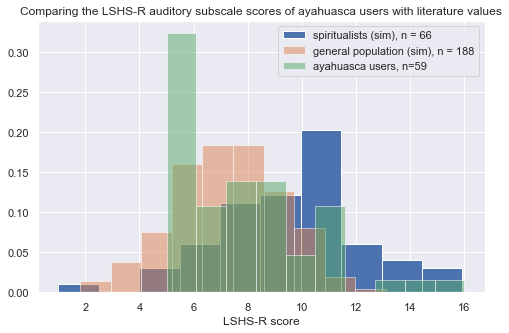

In [202]:
# they report a mean and stf --> we can simulate their distribution and then use a M-W non-parametric test to compare

#simulate their data
mean_spiri, sigma_spiri, n_spiri = 10.20, 3.05, 66 # mean and standard deviation
mean_gen, sigma_gen, n_gen     = 7.36, 2.05, 188 # mean and standard deviation

sim_spiri = np.random.normal(mean_spiri, sigma_spiri, n_spiri)
sim_gen = np.random.normal(mean_gen, sigma_gen, n_gen)
aya_hs = df_scales['HS_SCORE_auditory'].dropna()

plt.hist(sim_spiri, label = 'spiritualists (sim), n = 66', density = True)
plt.hist(sim_gen, alpha = 0.5, label = 'general population (sim), n = 188' , density = True)
plt.hist(aya_hs, alpha = 0.5, label = f'ayahuasca users, n={len(aya_hs)}', density = True)
plt.legend()
plt.xlabel('LSHS-R score')
plt.title('Comparing the LSHS-R auditory subscale scores of ayahuasca users with literature values')

#perform the Mann-Withney U test
U1, p1 = mannwhitneyu(aya_hs, sim_spiri, method="exact")
U2, p2 = mannwhitneyu(aya_hs, sim_gen, method="exact")

print(f'Comparing our data with the simulated spiritualist data {U1,p1}')
print(f'Comparing our data with the simulated gen population data {U2,p2}')

#### comparing with values from spiri paper; visual subscale

Comparing our data with the simulated spiritualist data (1517.0, 0.03333363099282187)
Comparing our data with the simulated gen population data (6049.0, 0.2947739639209904)


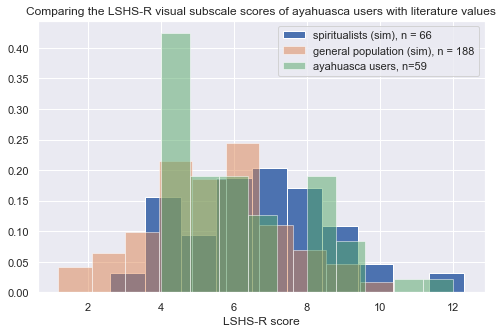

In [276]:
# they report a mean and stf --> we can simulate their distribution and then use a M-W non-parametric test to compare

#simulate their data
mean_spiri, sigma_spiri, n_spiri = 6.37, 2.32, 66 # mean and standard deviation
mean_gen, sigma_gen, n_gen     = 5.63, 1.9, 188 # mean and standard deviation

sim_spiri = np.random.normal(mean_spiri, sigma_spiri, n_spiri)
sim_gen = np.random.normal(mean_gen, sigma_gen, n_gen)
aya_hs = df_scales['HS_SCORE_visual'].dropna()

plt.hist(sim_spiri, label = 'spiritualists (sim), n = 66', density = True)
plt.hist(sim_gen, alpha = 0.5, label = 'general population (sim), n = 188' , density = True)
plt.hist(aya_hs, alpha = 0.5, label = f'ayahuasca users, n={len(aya_hs)}', density = True)
plt.legend()
plt.xlabel('LSHS-R score')
plt.title('Comparing the LSHS-R visual subscale scores of ayahuasca users with literature values')

#perform the Mann-Withney U test
U1, p1 = mannwhitneyu(aya_hs, sim_spiri, method="exact")
U2, p2 = mannwhitneyu(aya_hs, sim_gen, method="exact")

print(f'Comparing our data with the simulated spiritualist data {U1,p1}')
print(f'Comparing our data with the simulated gen population data {U2,p2}')
plt.savefig('group_comparison.pdf')

### Are the two tests' scores correlated?

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'TAS VS HS scores')

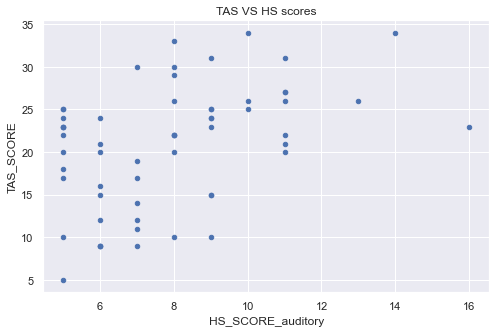

In [204]:
from scipy import stats
# test whether the scales correlate with each other
df_scales.plot.scatter('HS_SCORE_auditory','TAS_SCORE')
plt.title('TAS VS HS scores')

<AxesSubplot:>

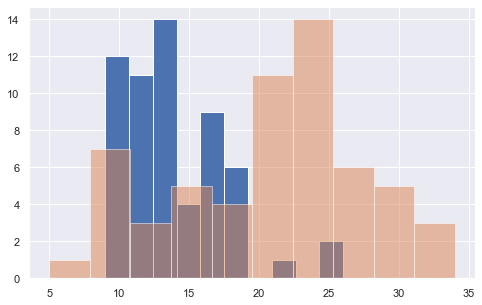

In [205]:
df_scales['HS_SCORE'].hist() #blue
df_scales['TAS_SCORE'].hist(alpha = 0.5) #orange

In [79]:
# spearman's correlation
# this does not assumes normality <---- THIS IS THE ONE WE USE!!
from scipy.stats import spearmanr

clean_df = df_scales[['HS_SCORE','TAS_SCORE','HS_SCORE_auditory','HS_SCORE_visual']]

# Calculate Spearman's rank correlation
correlation, p_value = spearmanr(clean_df['HS_SCORE_visual'], clean_df['TAS_SCORE'])

print(f"Spearman's rank correlation: {correlation}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")


#For a dataframe with many columns

# Calculate Spearman's rank correlation for all pairs of columns
correlation_matrix = clean_df.corr(method='spearman')

print("\nSpearman's Rank Correlation Matrix:")
print(correlation_matrix)

Spearman's rank correlation: 0.3510124336379893
P-value: 0.006414347676403201
The correlation is statistically significant.

Spearman's Rank Correlation Matrix:
                   HS_SCORE  TAS_SCORE  HS_SCORE_auditory  HS_SCORE_visual
HS_SCORE           1.000000   0.504183           0.863487         0.787192
TAS_SCORE          0.504183   1.000000           0.443147         0.351012
HS_SCORE_auditory  0.863487   0.443147           1.000000         0.398827
HS_SCORE_visual    0.787192   0.351012           0.398827         1.000000


In [80]:
from scipy.stats import pearsonr, shapiro, kstest, normaltest

# Sample Data (Replace with your actual data)
# ... (same as above)

# Check for normality (example using Shapiro-Wilk test)
for column in clean_df.columns:
    statistic, p_value = shapiro(clean_df[column]) #small samples, <50
    #statistic, p_value = normaltest(clean_df[column]) #larger samples
    #statistic, p_value = kstest(df[column],'norm') #use with caution, assumes data is continuous
    print(f"Normality test for {column}:")
    print(f"Statistic: {statistic}, P-value: {p_value}")
    alpha = 0.05
    if p_value > alpha:
        print(f"{column} appears to be normally distributed (fail to reject null hypothesis).")
    else:
        print(f"{column} does not appear to be normally distributed (reject null hypothesis).")
# is not normally distributed!!!
        
# Calculate Pearson's correlation (if normality assumptions are met)
#correlation, p_value = pearsonr(clean_df['TAS_SCORE'], clean_df['HS_SCORE'])

#print(f"\nPearson's correlation: {correlation}")
#print(f"P-value: {p_value}")

# Calculate Pearson's correlation matrix
#correlation_matrix = clean_df.corr(method='pearson')

#print("\nPearson's Correlation Matrix:")
#print(correlation_matrix)

Normality test for HS_SCORE:
Statistic: 0.9212173819541931, P-value: 0.0009573747520335019
HS_SCORE does not appear to be normally distributed (reject null hypothesis).
Normality test for TAS_SCORE:
Statistic: 0.9630787372589111, P-value: 0.07063238322734833
TAS_SCORE appears to be normally distributed (fail to reject null hypothesis).
Normality test for HS_SCORE_auditory:
Statistic: 0.9096174240112305, P-value: 0.00033825033460743725
HS_SCORE_auditory does not appear to be normally distributed (reject null hypothesis).
Normality test for HS_SCORE_visual:
Statistic: 0.8682948350906372, P-value: 1.2785250874003395e-05
HS_SCORE_visual does not appear to be normally distributed (reject null hypothesis).
